# HOUSE PRICES a regression problem:
in this notebook I have been working on the open dataset from Kaggle on predicting house prices given a list of 81 variables. I compared a number of different approaches from Random Forest (with a grid to refine the parameter estimation) to a NN built on Keras.

In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
#reading my data
train = pd.read_csv('gdrive/MyDrive/house_prices/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('gdrive/MyDrive/house_prices/house-prices-advanced-regression-techniques/test.csv')

all_data = pd.concat([train, test])

In [37]:
all_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732.0,Unf,0.0,64.0,796.0,GasA,...,Y,SBrkr,796,566,0,1362,1.0,0.0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2.0,480.0,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000.0
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369.0,Unf,0.0,317.0,1686.0,GasA,...,Y,SBrkr,1694,0,0,1694,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2.0,636.0,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000.0
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,...,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000.0
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,GasA,...,Y,FuseF,1022,752,0,1774,0.0,0.0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2.0,468.0,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900.0
9,10,190,RL,50.0,7420,Pave,N

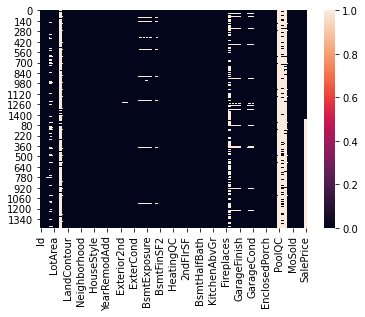

In [38]:
# start checking for null values
sns.heatmap(all_data.isnull())

# it appears to be quite some of them

In [39]:
# here I am selecting all columns with non nan more than half of the nrows in the dataset

columns_preserved = []
for i in range(len(all_data.columns)):
  #print(i)
  if all_data.isnull().sum()[i] < 0.5 * all_data.shape[0]:
    #print('columns preserved are ' , train.columns[i], 'with ', train.isnull().sum()[i], ' nan')
    columns_preserved.append(all_data.columns[i])
  else:
    pass

print(columns_preserved)
all_data_new = all_data[columns_preserved]
all_data_new.shape # we can see that 82- 77 columns have been eliminated

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSol

(2919, 77)

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 77, dtype: int64

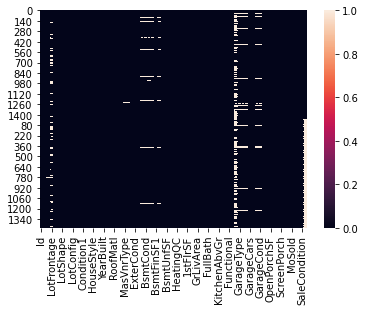

In [40]:
# check again for null values
sns.heatmap(all_data_new.isnull())
all_data_new.isnull().sum()

In [41]:
# print which columsn exactly do have null values
all_data_new.isnull().sum().to_string()

'Id                  0\nMSSubClass          0\nMSZoning            4\nLotFrontage       486\nLotArea             0\nStreet              0\nLotShape            0\nLandContour         0\nUtilities           2\nLotConfig           0\nLandSlope           0\nNeighborhood        0\nCondition1          0\nCondition2          0\nBldgType            0\nHouseStyle          0\nOverallQual         0\nOverallCond         0\nYearBuilt           0\nYearRemodAdd        0\nRoofStyle           0\nRoofMatl            0\nExterior1st         1\nExterior2nd         1\nMasVnrType         24\nMasVnrArea         23\nExterQual           0\nExterCond           0\nFoundation          0\nBsmtQual           81\nBsmtCond           82\nBsmtExposure       82\nBsmtFinType1       79\nBsmtFinSF1          1\nBsmtFinType2       80\nBsmtFinSF2          1\nBsmtUnfSF           1\nTotalBsmtSF         1\nHeating             0\nHeatingQC           0\nCentralAir          0\nElectrical          1\n1stFlrSF            0\n2ndFlrSF  

In [42]:
# FireplaceQu appears to have still too many (1420 nan, which are still less than 50% of the nrows of the dataset)
# drop also the id column, as it carries no relevant information
all_data_new.drop(['FireplaceQu'], axis=1, inplace=True)
all_data_new.drop(['Id'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [43]:
# here I am filling nan with the median and the mode depending if the column is a integer or a category
for i in all_data_new.columns[:-1]:
  if all_data_new[i].dtypes == object:
    #print(i, 'is an object and the mode is', all_data_new[i].mode()[0])
    all_data_new[i] = all_data_new[i].fillna(all_data_new[i].mode()[0])
  else:
    #print(i, 'IS NOT OBJECT and the median is', all_data_new[i].median() )
    all_data_new[i] = all_data_new[i].fillna(all_data_new[i].median())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
Street              0
                 ... 
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice        1459
Length: 75, dtype: int64

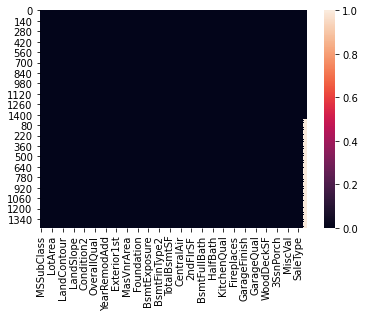

In [44]:
# check for nan, now there shold be none, apart for those of the sales in the rows of the test dataset (lower part)
sns.heatmap(all_data_new.isnull())
all_data_new.isnull().sum()

## Avoid multicollinearity

now I will eliminate those variables that are highly correlated. First I will check the numerical variables with a simple Rsquared and then I will check the categorical with a chi square test

11 10
21 14
25 24
{'GrLivArea', 'TotalBsmtSF', 'GarageCars'}
3


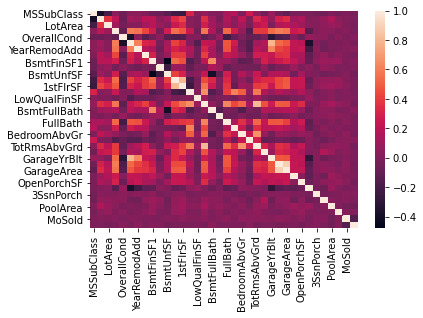

In [46]:
# check for correlation between numerical variables
# it appears that the last 5-6 variables are really little correlated (around 0 percent, violet colour)
sns.heatmap(all_data_new.iloc[:,:-1].corr())
highly_corr = []
corr = all_data_new.iloc[:,1:-1].corr()

for i in range(corr.shape[1]):
  for j  in range(corr.shape[0]-i):
    
     if abs(corr.iloc[j+i,i]) > 0.8 and corr.iloc[j+i,i] !=  1.0: # I am eliminating all num variables that are more than +/- 80% correlated wiht others
       print(j+i, i)
       highly_corr.append(corr.columns[i])

print(set(highly_corr))
print(len(set(highly_corr)))

In [47]:
# I create a list of the columns that will be passed in the function in the next cell, and in the dummies creation later on
columns_obj = all_data_new.columns[all_data_new.dtypes == object]
columns_obj 

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [48]:
# here I am checking for correlation between categorical variables, with the chi-square test
from scipy.stats import chi2_contingency

def corr_categorical (data, cat_variables): # this function returns the n. of variables that are higly correlated
  pv = []
  for i in range(len(cat_variables)):
    for j in cat_variables[i:]:
      
      cont = pd.crosstab(data[cat_variables[i]], data[j]) # making the contingency table
      
      if not any(cont < 5): # checking that all values are more or equal than 5
        g, p, dof, expctd = chi2_contingency(cont) # applying the chi square test
        
        if p < 0.05: 
          pv.append(p)
  return len(pv) 

corr_categorical(all_data_new, columns_obj)
# none of the categorical variables appear to be corelated and at the same time respecting the principles of hte chi square test (at least 5 elements for each combination)

0

In [49]:
# check how the categorical variables are distributed in their counts
for i in columns_obj:
  print(all_data_new[i].value_counts())

# the distribution of the levels are really uneven among the categories. Maybe because I added to the largest category all the nan
# not really because I see that the first category is often way way higher than the second, and 
# often accounts for more than 50% of all the rows

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
Pave    2907
Grvl      12
Name: Street, dtype: int64
Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64
Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64
AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64
Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64
Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64
Norm      2511
Feedr      164
Artery 

In [50]:
# check how often the first level of the cat accounts for more than 50% of all the rows
yes = []
col_obj_balanced = []

for i in columns_obj:
  if all_data_new[i].value_counts()[0] > 0.5 * sum(all_data_new[i].value_counts()):
    yes.append(1)
  else:
    col_obj_balanced.append(i) # these are the cat variables that look a bit more balanced
print('in ', round(len(yes)/len(columns_obj) * 100,1), '% of the cases the first level accounts for more than 50 % of the rows')

# this explains why we cannot run a chi square test

in  81.6 % of the cases the first level accounts for more than 50 % of the rows


In [ ]:
# the last step is to check for correlation between categorical variables and numerical variables. 
# However I can run it only for those variables that are at least a bit not so unbalanced
for i in col_obj_balanced:
  print(all_data_new[i].value_counts())
# they re also so unbalanced that I do not trust any type of conclusion that I would draw from an ANOVA (maybe use some test more robust to disrproportional and unbalanced designs)


## Prepare the dummies to run the models

In [79]:
 #create a function that transforms all obj columns in dummies, and then drops the original columns

def category_onehot_multcols(multcolumns, data):
    df_final = data.copy()
    i = 0
    for fields in multcolumns:
        
        #print(fields)
        df1 = pd.get_dummies(all_data_new[fields], drop_first = True)
        
        all_data_new.drop([fields], axis = 1, inplace = True)
        if i == 0:
            df_final = df1.copy()
        else:
            
            df_final = pd.concat([df_final,df1], axis = 1)
        i = i + 1
       
        
    df_final = pd.concat([all_data_new, df_final],axis = 1)
        
    return df_final


In [ ]:
# I transform the dataset with the function defined in the previous cell, now it is ready for the sklearn model
final_df = category_onehot_multcols(columns_obj, all_data_new)
final_df.head()

In [81]:
# dropping the duplicated columns
final_df = final_df.loc[:, ~final_df.columns.duplicated()]
final_df.shape

(2919, 177)

In [82]:
# divide the dataset between train and test, the test begins at row number 1460
df_Train = final_df.iloc[:1460,:]
df_Test = final_df.iloc[1460:,:]

# for the test drop saleprice as it contains nan
df_Test.drop(['SalePrice'], axis = 1, inplace = True)

# for the train divide between x train and y train
X_train = df_Train.drop(['SalePrice'], axis = 1)
y_train = df_Train['SalePrice']

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Here I am finally applying the statistical model.
## in this case I simply chose for a random forest

In [ ]:
# dowload sklearn for the model, in this casde RandomForestRegressor
# regressor since it is a regression problem

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(random_state = 1)
cv = cross_val_score(rf, X_train, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.86615628 0.83612745 0.87553903 0.87819325 0.81470068]
0.8541433372465971


In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [ ]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [ ]:
# Because the total feature space is so large, I used a randomized search to narrow down the paramters for the model. 
# I took the best model from this and did a more granular search 
"""
rf = RandomForestRegressor(random_state = 1)
param_grid =  {'n_estimators': [100,500,1000], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}
                                  
rgr_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_rgr_rf_rnd = rgr_rf_rnd.fit(X_train_scaled,y_train)
rgr_performance(best_rgr_rf_rnd,'Random Forest')"""

In [ ]:
# here I apply the random search with a grid
rf = RandomForestRegressor(random_state = 1)
param_grid =  {'n_estimators': [100, 200, 250, 300],
               'criterion':['mse', 'mae'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
rgr_rf = GridSearchCV(rf, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1, return_train_score=True) # best random forest
best_rgr_rf = clf_rf.fit(X_train,y_train) # best regressor random forest
rgr_performance(best_clf_rf,'Random Forest')

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 78.0min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 80.7min finished


Random Forest
Best Score: 0.8511469699199363
Best Parameters: {'bootstrap': True, 'criterion': 'mae', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
#Here I saved the results of the grid search
"""
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 78.0min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 80.7min finished
Random Forest
Best Score: 0.8511469699199363
Best Parameters: {'bootstrap': True, 'criterion': 'mae', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
"""

In [ ]:
#here I am saving the best parameters adn running the cross validation with them
best_rgr_rf = RandomForestRegressor(bootstrap = True, criterion= 'mae', max_depth = 20, max_features= 'auto', min_samples_leaf = 2, min_samples_split = 2, n_estimators = 200)

cv = cross_val_score(best_rf, X_train, y_train, cv = 5)
print(cv)
print(cv.mean()) # you can see that it is slightly better

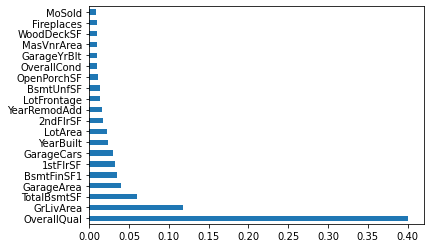

In [ ]:
# and here finally I am plotting the feature importance. There will be sooo many
best_rf = best_rgr_rf.fit(X_train,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index = X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
'''
best_rf = best_clf_rf.best_estimator_.fit(X_train,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')
'''

## build the ANN on keras

In [83]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,FV,RH,RL,RM,...,No,BLQ,GLQ,LwQ,Rec,Unf,GasA,GasW,Grav,OthW,Wall,Y,FuseF,FuseP,Mix,SBrkr,Maj2,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [57]:
 # get the column index from where the cat variables begin 
 X_train.columns.get_loc("YrSold")

35

In [58]:
# Here I am simply scaling the numerical variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train.iloc[:,:35] = scaler.fit_transform(X_train.iloc[:,:35] )

In [74]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,FV,RH,RL,RM,...,No,BLQ,GLQ,LwQ,Rec,Unf,GasA,GasW,Grav,OthW,Wall,Y,FuseF,FuseP,Mix,SBrkr,Maj2,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,0.073375,-0.212720,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,1.161852,-0.120242,0.370333,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,0.912210,-0.951226,1.020003,0.311725,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,2008,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,-0.872563,0.468158,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,-0.641228,0.466465,0.257140,-0.795163,-0.120242,-0.482512,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.211454,-0.318683,0.600495,-0.105624,0.311725,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,2007,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0.073375,-0.076544,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,-0.301643,-0.313369,-0.627826,1.189351,-0.120242,0.515013,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,-0.318683,0.600495,0.936623,0.311725,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,2008,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0.309859,-0.439679,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,-0.061670,-0.687324,-0.521734,0.937276,-0.120242,0.383659,1.107810,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,0.296763,0.600495,0.811554,1.650307,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,2006,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0.073375,0.649725,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,-0.174865,0.199680,-0.045611,1.617877,-0.120242,1.299326,1.107810,-0.241061,0.789741,1.227585,1.390023,-0.211454,1.527656,0.600495,0.894933,1.650307,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,2008,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [121]:
# building a simple NN model
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(100, activation='relu', input_shape=(176,), kernel_initializer='normal'))

model.add(Dense(50, activation='relu', kernel_initializer='normal'))
model.add(Dense(50, activation='relu', kernel_initializer='normal'))

model.add(Dense(1, activation='relu', kernel_initializer='normal'))# I first tried with the sigmoid function but it did not work, the loss
# function was remaining constant (https://discuss.pytorch.org/t/loss-remains-constant-unchanged/99630). 

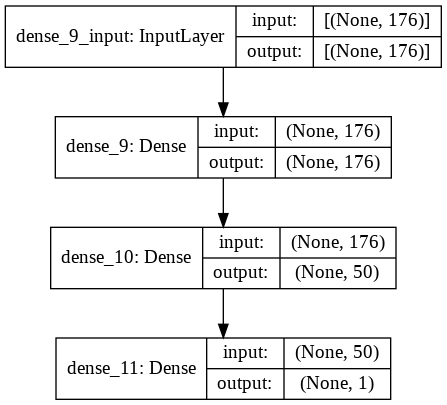

In [65]:
from keras.utils import plot_model
plot_model(model, to_file = '/tmp/model.png', show_shapes = True,)

In [94]:
# prepare the y train for the keras NN
y_train = np.ravel(y_train)
y_train

array([208500., 181500., 223500., ..., 266500., 142125., 147500.])

In [122]:
# I am compiling the model, I use mean squared error and the adam optimizer (I could have used the sgd + momentum)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
                   
history = model.fit(X_train, y_train, validation_split = 0.20, epochs = 100, batch_size = 10, verbose = 1)

117/117 [==============================] - 0s 3ms/step - loss: 1259077226.5763 - mse: 1259077226.5763 - val_loss: 4096046336.0000 - val_mse: 4096046336.0000
Epoch 94/100
117/117 [==============================] - 0s 3ms/step - loss: 1260524336.8136 - mse: 1260524341.1525 - val_loss: 3742778368.0000 - val_mse: 3742778624.0000
Epoch 95/100
117/117 [==============================] - 0s 3ms/step - loss: 1064045653.1525 - mse: 1064045752.4068 - val_loss: 4138131200.0000 - val_mse: 4138131200.0000
Epoch 96/100
117/117 [==============================] - 0s 2ms/step - loss: 1438650613.6949 - mse: 1438650613.6949 - val_loss: 3923636736.0000 - val_mse: 3923636736.0000
Epoch 97/100
117/117 [==============================] - 0s 3ms/step - loss: 1321267620.8814 - mse: 1321267620.8814 - val_loss: 4039882240.0000 - val_mse: 4039882240.0000
Epoch 98/100
117/117 [==============================] - 0s 3ms/step - loss: 1278646116.8814 - mse: 1278646116.8814 - val_loss: 3679222784.0000 - val_mse: 367922278

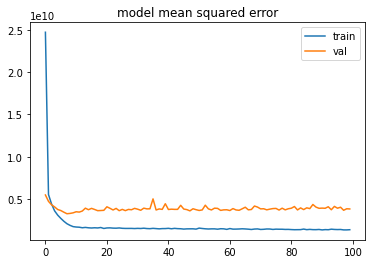

In [132]:
# plot of the model performances
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squared error')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

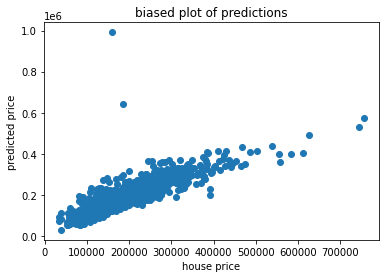

In [146]:
# here we plot the predicted against the actual values. However this plot is highly biased,
#i should have plotted against the test dataset
plt.scatter(y_train,model.predict(X_train))
plt.title('biased plot of predictions')
plt.xlabel('house price')
plt.ylabel('predicted price')
plt.show()